In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch.nn as nn
import torch
import idx2numpy 
from torchvision.transforms.functional import gaussian_blur
from torch import optim

from matplotlib import pyplot as plt
from deepshape.surfaces import * 

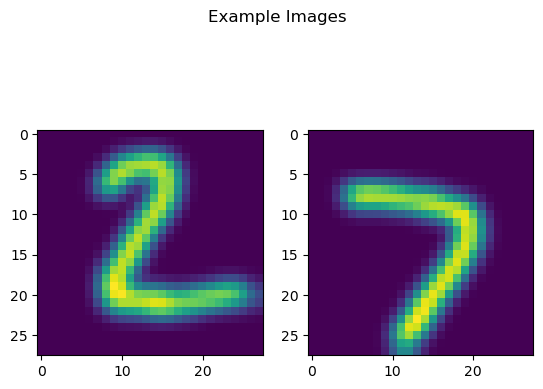

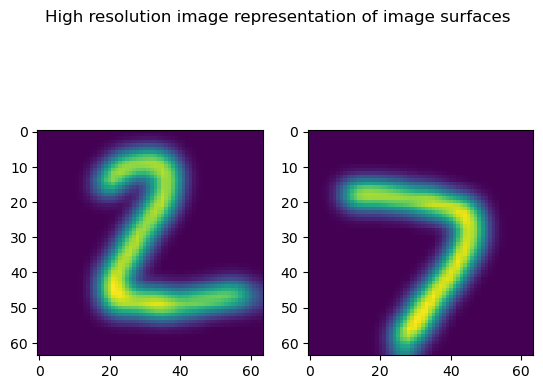

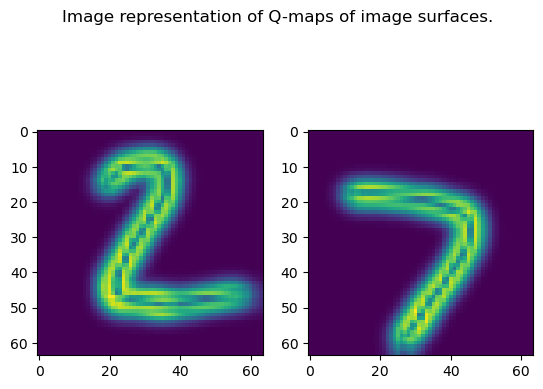

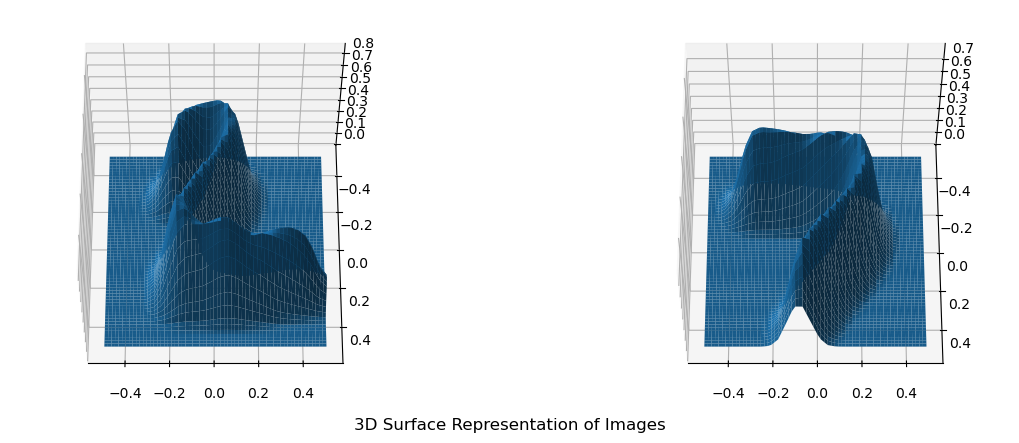

In [3]:
# Load Data
imgfile = "../data/t10k-images.idx3-ubyte"
imgdata = torch.tensor( idx2numpy.convert_from_file(imgfile), dtype=torch.float )
labelfile = "../data/t10k-labels.idx1-ubyte"
labels = torch.tensor( idx2numpy.convert_from_file(labelfile))
imgdata = gaussian_blur(imgdata, [5, 5])
imgdata /= imgdata.max()

# Extract example images
img1 = imgdata[1]
img2 = imgdata[17]

fig, (ax1, ax2 )= plt.subplots(1, 2)
ax1.imshow(img1)
ax2.imshow(img2)
plt.suptitle("Example Images")
plt.show()

# Create surface representation of images
f = SingleChannelImageSurface(img1, centering=True, scaling=False, mode='bicubic')
g = SingleChannelImageSurface(img2, centering=True, scaling=False, mode='bicubic')

# Find example data of surface representations of the images.
k = 64
XX = torch_square_grid(k=k)
X = XX.view(-1, 2)
Zf = f(XX).permute(2, 0, 1).numpy()
Zg = g(XX).permute(2, 0, 1).numpy()

# Plotting
fig, (ax1, ax2 )= plt.subplots(1, 2)
ax1.imshow(Zf[2])
ax2.imshow(Zg[2])
plt.suptitle("High resolution image representation of image surfaces")
plt.show()

# Create sample data of Q-map representations of the images.
q = Qmap(f)
r = Qmap(g)
Zq = q(XX).permute(2, 0, 1).numpy()
Zr = r(XX).permute(2, 0, 1).numpy()

# Plot the q-map representation as images.
fig, (ax1, ax2 )= plt.subplots(1, 2)
ax1.imshow(Zq[2])
ax2.imshow(Zr[2])
plt.suptitle("Image representation of Q-maps of image surfaces.")
plt.show()


# 3D-plot of the surface representation of the images. 
fig = plt.figure(figsize=(12, 4))
fig.suptitle("3D Surface Representation of Images")
ax = plt.axes((0., 1., 0.5, 1.), projection='3d')
ax.plot_surface(*Zf, rstride=1, cstride=1)
ax.view_init(+60, -270)
ax.invert_xaxis()

ax = plt.axes((0.5, 1., 0.5, 1.), projection='3d')
ax.plot_surface(*Zg, rstride=1, cstride=1)
ax.view_init(+60, -270)
ax.invert_xaxis()
plt.show(fig)

[Iter     1] loss: 0.459045
[Iter     2] loss: 0.427439
[Iter     3] loss: 0.344075
[Iter     4] loss: 0.307890
[Iter     5] loss: 0.299981
[Iter     6] loss: 0.230730
[Iter     7] loss: 0.230204
[Iter     8] loss: 0.226989
[Iter     9] loss: 0.225203
[Iter    10] loss: 0.225168
[Iter    11] loss: 0.214466
[Iter    12] loss: 0.204302
[Iter    13] loss: 0.202027
[Iter    14] loss: 0.166551
[Iter    15] loss: 0.146258
[Iter    16] loss: 0.144278
[Iter    17] loss: 0.143474
[Iter    18] loss: 0.140209
[Iter    19] loss: 0.136786
[Iter    20] loss: 0.135721
[Iter    21] loss: 0.133097
[Iter    22] loss: 0.132667
[Iter    23] loss: 0.128706
[Iter    24] loss: 0.126827
[Iter    25] loss: 0.125887
[Iter    26] loss: 0.124906
[Iter    27] loss: 0.123773
[Iter    28] loss: 0.122446
[Iter    29] loss: 0.119959
[Iter    30] loss: 0.118235
[Iter    31] loss: 0.117719
[Iter    32] loss: 0.111380
[Iter    33] loss: 0.110220
[Iter    34] loss: 0.108198
[Iter    35] loss: 0.107945
[Iter    36] loss: 0

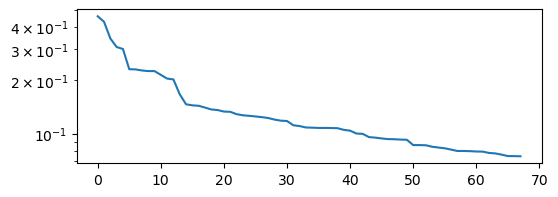

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# Define reparametrization-network
RN = SurfaceReparametrizer(
    [SineLayer(min(5, 15-i), init_scale=0.0) for i in range(15)]
).to(device)

optimizer = optim.LBFGS(RN.parameters(), max_iter=100, line_search_fn="strong_wolfe")

scheduler = None
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.9, patience=1, threshold=0.,
#     threshold_mode='rel', cooldown=1, min_lr=1e-6, eps=1e-08,
#     verbose=True)


# loss_func = ShapeDistance(q, r, k=64, h=1e-4).to(device)
loss_func = ImageComponentDistance(q, r, k=32, h=1e-4).to(device)
errors = reparametrize(RN, loss_func, optimizer, 100, Logger(1))#scheduler=scheduler)


RN.to("cpu"), loss_func.to("cpu");

plt.figure(figsize=(6, 2))
plt.semilogy(errors)
plt.show()

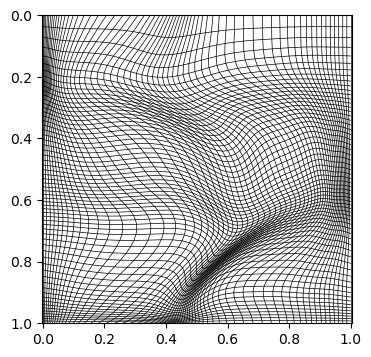

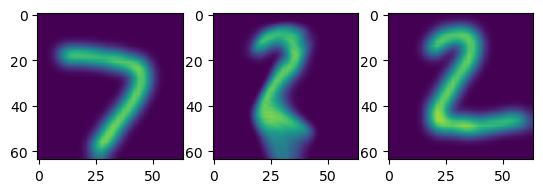

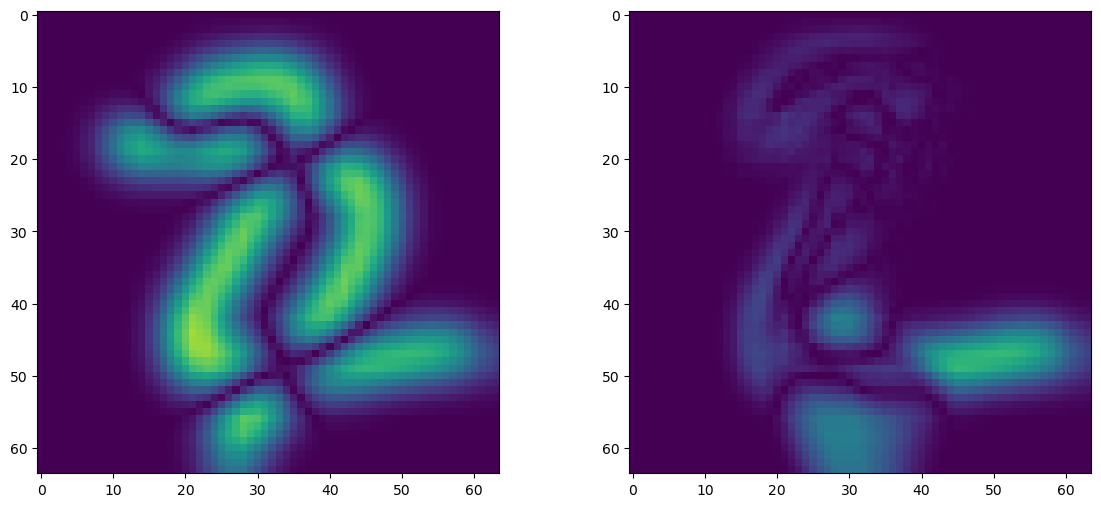

In [5]:
3# =============== PLotting below +============
u = lambda x: RN(x)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_diffeomorphism(u, k=64, ax=ax, color="k", lw=0.5)
plt.axis("equal")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.gca().invert_yaxis()
plt.savefig("/home/jorgen/deepshape/figures/1-2-warp-diffeomorphism.pdf")


fphi = f.compose(u)
gphi = g.compose(u)

Zff = fphi(X).view(k, k, 3).detach().numpy()
Zgg = gphi(X).view(k, k, 3).detach().numpy()

fig, (ax1, ax2 , ax3)= plt.subplots(1, 3)
ax1.imshow(Zg[2],  vmin=0., vmax=1.)
ax2.imshow(Zgg[..., 2], vmin=0., vmax=1.)
ax3.imshow(Zf[2], vmin=0., vmax=1.)
plt.savefig("/home/jorgen/deepshape/figures/1-2-warp.pdf")
plt.show()

fig, (ax1, ax3,)= plt.subplots(1, 2, figsize=(14, 6))
ax1.imshow(np.abs(Zf[2] - Zg[2]), vmin=0., vmax=1.)
ax3.imshow(np.abs(Zf[2] - Zgg[..., 2]), vmin=0., vmax=1.)
plt.savefig("/home/jorgen/deepshape/figures/1-2-warp-error.pdf")
plt.show()

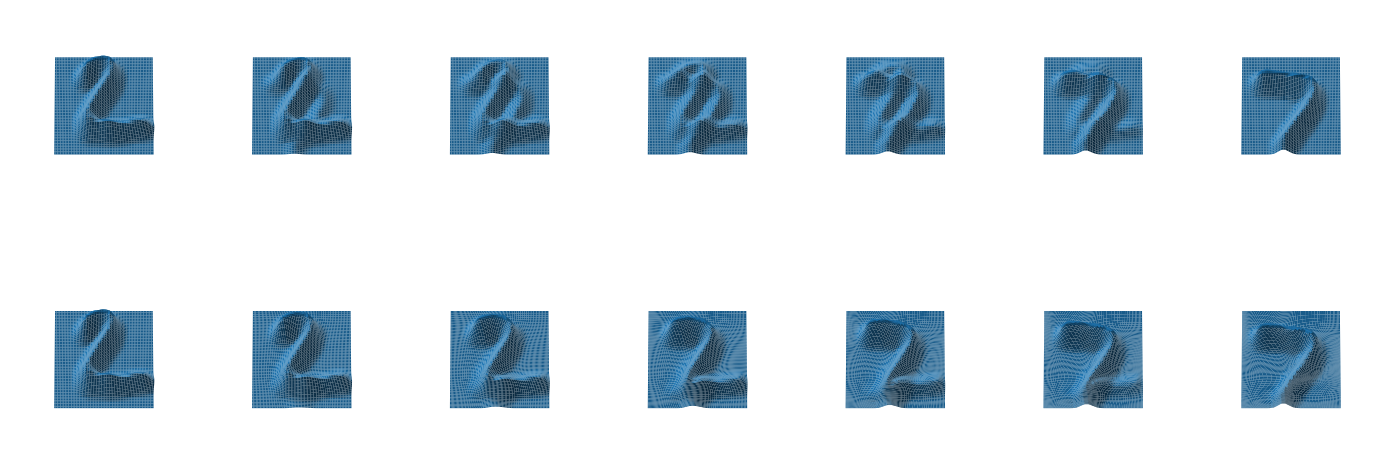

In [6]:
numsteps = 7
def interpolate(f, g, t):
    return lambda x: (1 - t) * f(x) + t * g(x)

def geodesics(f, g, steps=numsteps):
    t = np.linspace(0, 1, steps)
    data = [None] * steps
    for i in range(steps):
        data[i] = interpolate(f, g, t[i])
        
    return data

with torch.no_grad():
    fig = plt.figure(figsize=(14, 6))
    for i, h in enumerate(geodesics(f, g)):
        ax = fig.add_subplot(2, numsteps, i+1, projection="3d")
        Z = h(X).view(k, k, 3).permute(2, 0, 1).detach().numpy()
        ax.plot_surface(*Z, rstride=1, cstride=1)
        ax.view_init(80, -270)
        ax.invert_yaxis()
        ax.set_axis_off()

    for i, h in enumerate(geodesics(f, lambda x: g(RN(x)))):
        ax = fig.add_subplot(2, numsteps, i+(numsteps+1), projection="3d")
        Z = h(X).view(k, k, 3).permute(2, 0, 1).detach().numpy()
        ax.plot_surface(*Z, rstride=1, cstride=1)
        ax.view_init(80, -270)
        ax.invert_yaxis()
        ax.set_axis_off()
    
    plt.tight_layout()
    plt.savefig("../figures/images/images-geodesic-surface.pdf")


    plt.show()

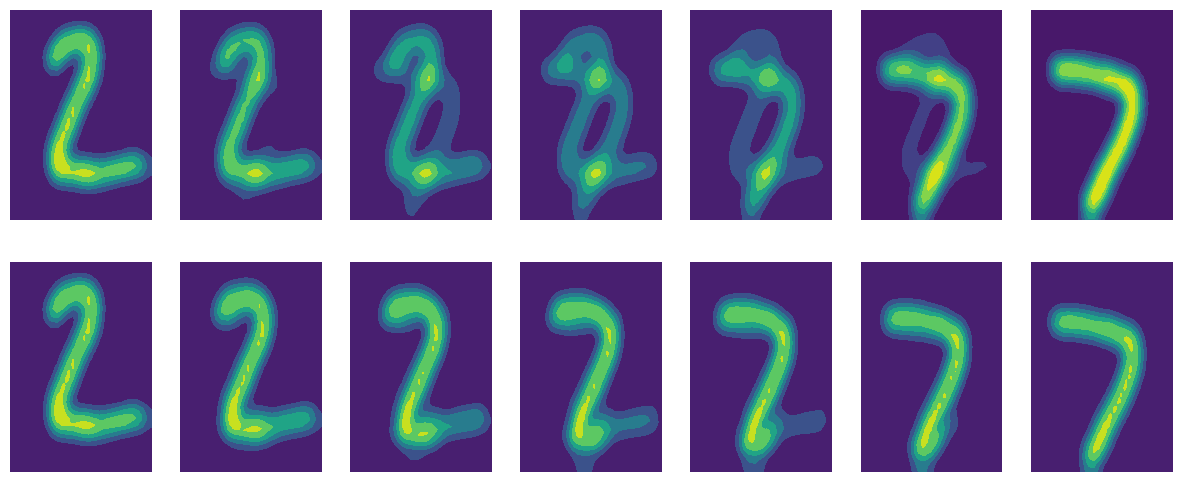

In [7]:
with torch.no_grad():
    fig = plt.figure(figsize=(15, 6))
    for i, h in enumerate(geodesics(f, g)):
        ax = fig.add_subplot(2, numsteps, i+1)
        Z = h(X).view(k, k, 3).permute(2, 0, 1).detach().numpy()
        ax.contourf(*Z)# optimizer = optim.SGD(RN.parameters(), lr=1e-1, momentum=0.2)

        ax.invert_yaxis()
        ax.set_axis_off()

    for i, h in enumerate(geodesics(f, lambda x: g(RN(x)))):
        ax = fig.add_subplot(2, numsteps, i+(numsteps+1))
        Z = h(X).view(k, k, 3).permute(2, 0, 1).detach().numpy()
        ax.contourf(*Z)
        ax.invert_yaxis()
        ax.set_axis_off()
    
    plt.savefig("../figures/images/images-geodesic-image.pdf")

    plt.show()